In [2]:
import torch 
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [5]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=1028, shuffle=True)
testloader = DataLoader(testset, batch_size=1028, shuffle=True)

In [7]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out
    
    
def get_model(h_size, input_size=784, num_classes=10):
    model = BaselineModel(input_size, h_size, num_classes)
    opt = optim.Adam(model.parameters())
    return model, opt

In [8]:
def eval_loop(model, testloader):
    loss_function = nn.CrossEntropyLoss()
    running_loss = 0
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        running_loss += loss.item()
    return running_loss/len(testloader)
    


def train_loop(h_size):
    model, opt = get_model(h_size)
    model.to(device)
    
    # Dataset
    trainset = MNIST(".", train=True, download=True, transform=transform)
    testset = MNIST(".", train=False, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = DataLoader(testset, batch_size=128, shuffle=True)

    loss_function = nn.CrossEntropyLoss()
    training_losses = []
    validation_losses = []
    accuracy = []
    
    for epoch in range(10):
        train_loss = 0.0
        val_loss = 0.0

        for data in trainloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            opt.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            opt.step()
            train_loss += loss.item()

        acc = []
        for val_data in testloader:
            inputs, labels = val_data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad(): 
                val_outputs = model(inputs)
                v_loss = loss_function(val_outputs, labels)
            preds = torch.argmax(val_outputs, dim=1)
            correct = [1 if preds[i] == label else 0 for i, label in enumerate(labels)]
            acc.append(sum(correct)/len(correct))
            val_loss += v_loss.item()
        validation_losses.append(val_loss/len(testloader))
        training_losses.append(train_loss/len(trainloader))
        accuracy.append(np.mean(acc))
    return training_losses, validation_losses, accuracy

In [9]:
tests = (10, 100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000)
train_losses = []
val_losses = []
all_accuracy = []

for test in tests:
    print(test)
    t_loss, val_loss, accuracy = train_loop(test)
    train_losses.append(np.array(t_loss))
    val_losses.append(np.array(val_loss))
    all_accuracy.append(np.array(accuracy))

10
100
500
1000
2000
4000
8000
16000
32000
64000


In [14]:
epochs = np.arange(10)
width = tests[2:]
X, Y = np.meshgrid(epochs, width)
Z = np.array(val_losses)[2:]

print(X.shape, Y.shape, Z.shape)

(8, 10) (8, 10) (0, 10)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8, 10) and arg 2 with shape (0, 10).

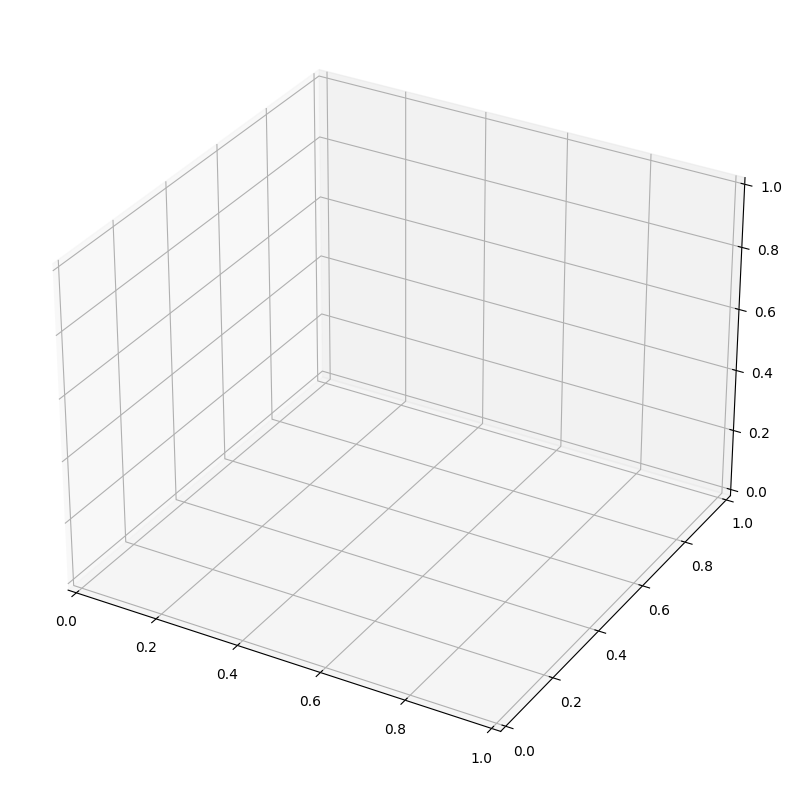

In [15]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.cividis)

# Set axes label
ax.set_xlabel('Epochs', labelpad=25)
ax.set_ylabel('Neurons', labelpad=25)
ax.set_zlabel('Validation Loss', labelpad=20)
ax.view_init(25,15)
plt.title("Validation Loss", fontsize=18)
fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()



IndexError: list index out of range

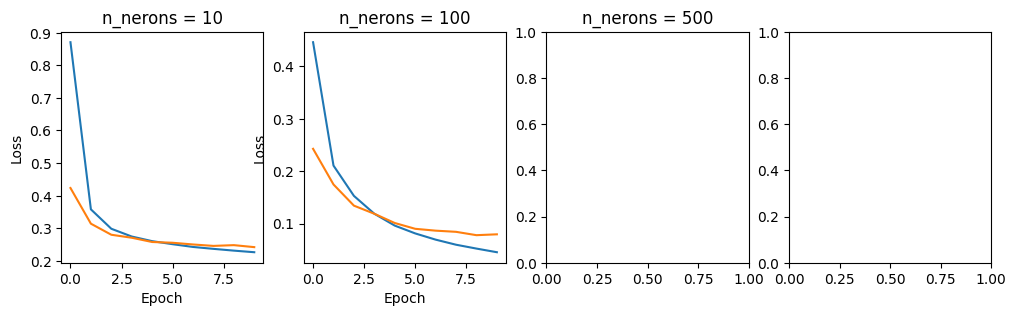

In [16]:

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
Z = np.array(val_losses)
for i in range(4):
    axes[i].set_title("n_nerons = " + str(tests[i]))
    axes[i].plot(train_losses[i], label="train")
    axes[i].plot(val_losses[i], label="val")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Loss")
plt.legend()

The universal approximation theorem shows that a shallow network of infinite width can learn any continuous function from data. In order to generalise well however the neural network must learn the underlying structure. Deep nets capture this structure by learning new hierachical representations of the data from layer to layer. Shallow nets can also achieve this for simple data but provided too many neurons, the networks can simply memorise the training. Certain neurons may only fire given a particular input. As many students may tell you memorization is not an effective technique for generalization to training set. However by constraining the neural network to few layers it forces it to learn a structure of the data that can generalize.

In [13]:
tests = (10, 100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000)
train_losses = []
val_losses = []
all_accuracy = []

for test in tests:
    print(test)
    t_loss, val_loss, accuracy = train_loop(test)
    train_losses.append(np.array(t_loss))
    val_losses.append(np.array(val_loss))
    all_accuracy.append(np.array(accuracy))

10
100
500


KeyboardInterrupt: 

(10, 7) (10, 7) (10, 7)


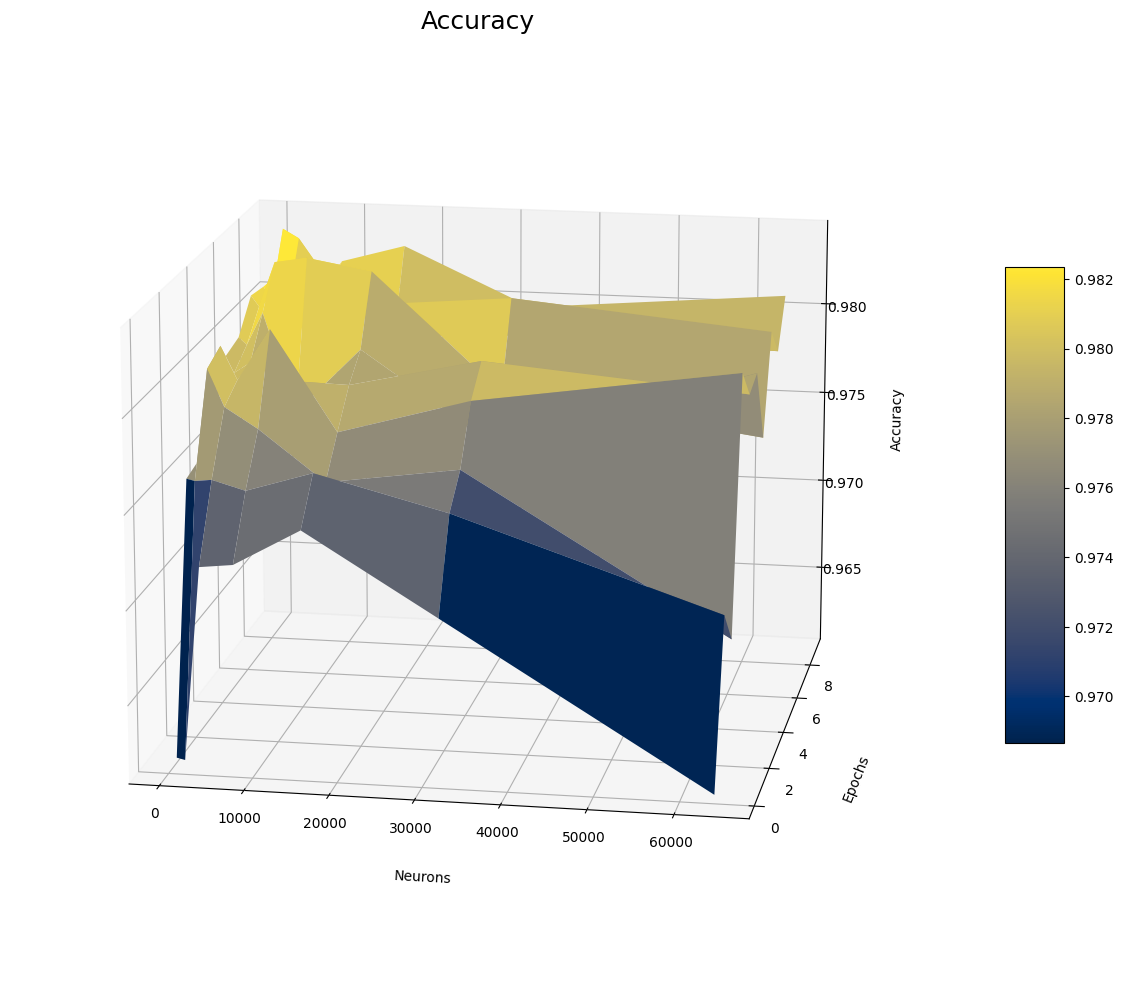

In [120]:



fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')
epochs = np.arange(10)
width = tests[3:]
X, Y = np.meshgrid(width, epochs)
Z = np.transpose(np.array(all_accuracy)[3:])
print(X.shape, Y.shape, Z.shape)
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.cividis)


# Set axes label
ax.set_xlabel('Neurons', labelpad=20)
ax.set_ylabel('Epochs', labelpad=20)
ax.set_zlabel('Accuracy', labelpad=20)
ax.view_init(15,-80)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.title("Accuracy", fontsize=18)
plt.tight_layout()
plt.show()